In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import seaborn as sns

#these are user defined modules
import plot
import calculate

### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

In [141]:
start_time = timeit.default_timer()
print(start_time)

1510329666.34


### Read Gender details

In [142]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_1970_2016_noAsians.csv')
gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender.groupby('gender').size())
#TODO: also show proportion! What is the percentage of men and women?

print(gender['author'].nunique())

             author gender
0    nima mesgarani      m
1    james j. abbas      m
2  eberhart zrenner      m
3    emery n. brown      m
4        ilya rybak      m
['m' 'none' 'f']
gender
f        974493
m       4493870
none     325482
dtype: int64
1129473


### Read authors with start and end year details

In [143]:
CAREER_LENGTH_LIST = [5,10,15,20,25,30]
CAREER_LENGTH = 15
#max_years = 15
authorStartEndCareerData = pd.read_csv('data/authors-scientific-start-end-year-publish-count.csv')
print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

#authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')
print(authorStartEndCareerData.head())

#print("authorStartEndCareerData  %s", authorStartEndCareerData.shape[0])
print("author unique names  - ", authorStartEndCareerData['author'].nunique())
#print(authorStartEndCareerData[authorStartEndCareerData['author']=='a min tjoa'])

('authorStartEndCareerData before filtering - ', 1708185)
('authorStartEndCareerData after filtering - ', 1708185)
                  author  start_year  end_year  pub_count
0       'maseka lesaoana        2001      2015          2
1  (max) zong-ming cheng        2009      2011          2
2       (zhou) bryan bai        2011      2012          2
3                  a lun        2010      2010          1
4             a min tjoa        1979      2015        193
('author unique names  - ', 1708185)


### Merge credible authors and their gender information

In [144]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
print(authorStartEndCareerData.head())

print("authorStartEndCareerData with duplicates: %s", authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: %s", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData['author'].nunique())

#axes = authorStartEndCareerData.boxplot(column='pub_count', by='gender', return_type='axes')
#for ax in axes.values():
#    ax.set_ylim(0, 200)
#plt.show()

                  author  start_year  end_year  pub_count gender
0       'maseka lesaoana        2001      2015          2   none
1       'maseka lesaoana        2001      2015          2   none
2  (max) zong-ming cheng        2009      2011          2   none
3       (zhou) bryan bai        2011      2012          2   none
4                  a lun        2010      2010          1   none
('authorStartEndCareerData with duplicates: %s', 6372557)
('authorStartEndCareerData no duplicates: %s', 1708185)


### Read Citation data

In [150]:
authorCitationsData = pd.read_csv('./data/authors_cite_2016_asiansAsNone.txt')
print('authorCitationsData before filtering - ',authorCitationsData.shape[0])
authorCitationsData = authorCitationsData[authorCitationsData["year"] >= 1970]
print('authorCitationsData after filtering - ',authorCitationsData.shape[0])

#id1 represents the author who cited
#id2 is the author who has been cited by id1 in year Y
authorCitationsData.rename(columns={'id2':'author'}, inplace=True)
print(authorCitationsData.head())

#Group by both year and author - multi index and hierarchial indexing
authorCitationsData = authorCitationsData.groupby(['year','author']).count().reset_index()
authorCitationsData.rename(columns={'id1':'num_cit'}, inplace=True)
print(authorCitationsData.head())

##remove wrong data
#authorCitationsData = authorCitationsData[authorCitationsData["year"] > 1900]
#print(authorCitationsData[authorCitationsData.author=="a min tjoa"])

('authorCitationsData before filtering - ', 1904817)
('authorCitationsData after filtering - ', 1904456)
              id1        author  year
0   stefano rizzi    qiong fang  2006
1   stefano rizzi  jianlin feng  2006
2   stefano rizzi    hulin ding  2006
3  alberto abelló    qiong fang  2006
4  alberto abelló  jianlin feng  2006
   year            author  num_cit
0  1970       a. a. afifi        3
1  1970        a. fischer        1
2  1970   albert r. meyer        2
3  1970     alfred v. aho        2
4  1970  azriel rosenfeld        3


### Merge Citations with credible authors and their gender information

('authorCitationsData with duplicates: %s', 346251)
('authorCitationsData without duplicates: %s', 346135)
148089
   year            author  num_cit  start_year  end_year  pub_count gender
0  1970       a. a. afifi        3        1970      1970          1   none
1  1970        a. fischer        1        2002      2014          3   none
2  1970   albert r. meyer        2        1970      2002         75      m
3  1970     alfred v. aho        2        1970      2015         67      m
4  1970  azriel rosenfeld        3        1970      2007        386      m


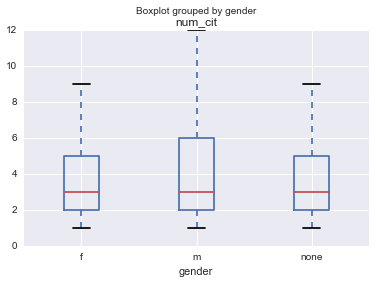

In [151]:
authorCitationsData = pd.merge(authorCitationsData, authorStartEndCareerData,  
                                          how="left", left_on="author", right_on="author")

print("authorCitationsData with duplicates: %s", authorCitationsData.shape[0])
authorCitationsData = authorCitationsData.dropna(how='any')
print("authorCitationsData without duplicates: %s", authorCitationsData.shape[0])

#print(authorCitationsData.head(n=2))
print(authorCitationsData['author'].nunique())
#print(authorCitationsData.shape[0])

print(authorCitationsData.head())
#print(authorCitationsData[authorCitationsData.author=="a min tjoa"])


authorCitationsData.boxplot(column='num_cit', by='gender', showfliers=False)
plt.show()

### There are some differences between publication and citation data which is collected by DBLP and Aminer respectively
#### Data found for authors whose work were cited in the years which are lesser than their starting year of publishing. For our analysis these data are removed. Whereas author's work will be cited even after he/she ends their career

In [152]:
print('authorCitationsData before filtering', authorCitationsData.shape[0])
temp =  authorCitationsData[authorCitationsData['year'] < authorCitationsData['start_year']]
print(temp.shape[0],' rows were present')

authorCitationsData = authorCitationsData[authorCitationsData['year'] >= authorCitationsData['start_year']]
authorCitationsData = authorCitationsData.reset_index()

print('authorCitationsData after filtering', authorCitationsData.shape[0])

('authorCitationsData before filtering', 346135)
(196, ' rows were present')
('authorCitationsData after filtering', 345939)


In [153]:
groupByYearData = authorCitationsData.copy(deep=True)
groupByYearData.head()
groupByYearData['year'].unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015])

In [ ]:
groupByYearData = authorCitationsData.copy(deep=True)
GROUP_YEAR = 3

if GROUP_YEAR > 1:
    MIN_YEAR = groupByYearData['year'].min() 
    MAX_YEAR = groupByYearData['year'].max() + 2*GROUP_YEAR
    yearGroups = range(MIN_YEAR, MAX_YEAR, GROUP_YEAR)
    groupByYearData['year'] = pd.cut(groupByYearData['year'], bins=yearGroups, labels=yearGroups[:-1],\
                                           include_lowest=True, right=False)
    groupByYearData['start_year'] = pd.cut(groupByYearData['start_year'],bins=yearGroups, labels=yearGroups[:-1],\
                                           include_lowest=True, right=False)
    groupByYearData['end_year'] = pd.cut(groupByYearData['end_year'],bins=yearGroups, labels=yearGroups[:-1],\
                                           include_lowest=True, right=False)
    
    temp = groupByYearData.groupby(['year', 'author'])
    temp =  temp['num_cit'].aggregate(np.sum)
    temp = temp.reset_index()
    
    temp1 = temp.set_index('year').sort_index()
    temp1 = temp1.groupby(['author'])['num_cit'].cumsum()
    temp1 = temp1.reset_index()
    temp1.rename(columns={'num_cit':'cum_num_cit'}, inplace=True)

    temp = pd.merge(temp1, temp, on=['year','author'], how='left')
    print("temp with duplicates: %s", temp.shape[0])
    temp = temp.drop_duplicates()
    print("temp without duplicates: %s", temp.shape[0])
    
    groupByYearData = groupByYearData.drop(['num_cit'], axis=1)
    groupByYearData = pd.merge(temp, groupByYearData, on=['year','author'], how='left')
    print("groupByYearData with duplicates: %s", groupByYearData.shape[0])
    groupByYearData = groupByYearData.drop_duplicates()
    print("groupByYearData without duplicates: %s", groupByYearData.shape[0])
    
    #### Tested with the following data - who has the highest publication record
    #groupByYearData[groupByYearData['author'] == 'donatella sciuto']
    
#groupByYearData['cum_num_cit'] = groupByYearData.groupby(['author'])['num_cit'].transform(pd.Series.cumsum)


#groupCitationsByAuthorYearData["cum_num_cit"] = groupCitationsByAuthorYearData.groupby(['author'])['num_cit'].transform(pd.Series.cumsum)
#groupCitationsByAuthorYearData = groupCitationsByAuthorYearData.reset_index()

#groupByAuthorYearData = groupByAuthorYearData.set_index('year').sort_index()
#print(groupByAuthorYearData.head())

#groupByAuthorYearData["cum_num_pub"] = groupByAuthorYearData.groupby(['author'])['num_pub'].transform(pd.Series.cumsum)

In [247]:
print(groupByYearData.shape)
print(groupByYearData.head(10))

#groupByYearData['num_cit1'] = groupByYearData['num_cit'].aggregate(np.sum)
#groupByYearData = groupByYearData.reset_index()
print(groupByYearData.shape)
print(groupByYearData.head(10))

(345939, 7)
    year                 author  num_cit start_year end_year  pub_count gender
0   1970            a. a. afifi        3       1970     1970          1   none
2   1970        albert r. meyer        2       1970     2000         75      m
3   1970          alfred v. aho        2       1970     2015         67      m
4   1970       azriel rosenfeld        3       1970     2006        386      m
5   1970        david f. martin        3       1970     2003         15   none
6   1970        dennis f. cudia        1       1970     1970          2      m
10  1970          gerald estrin        3       1970     2000         17      m
13  1970         herbert shubin        3       1970     1970          1   none
15  1970  james hardy wilkinson        3       1970     1973          3      m
16  1970       james l. elshoff        2       1970     1991         11      m
('groupByYearData with duplicates: %s', 345939)
('groupByYearData without duplicates: %s', 259854)
(259854, 7)
   year 

In [ ]:
groupByYearData['num_cit'] = ['num_cit'].transform(pd.Series.sum)

In [248]:
groupByYearData[groupByYearData['author'] == 'donatella sciuto']

year            author  num_cit  start_year  end_year  pub_count  \
10317   1994  donatella sciuto       30        1985      2015        348   
18025   1997  donatella sciuto      531        1985      2015        348   
33001   2000  donatella sciuto       68        1985      2015        348   
59741   2003  donatella sciuto     1078        1985      2015        348   
101967  2006  donatella sciuto      798        1985      2015        348   
171959  2009  donatella sciuto     1234        1985      2015        348   
267169  2012  donatella sciuto    33821        1985      2015        348   
343344  2015  donatella sciuto    11694        1985      2015        348   

       gender  
10317       f  
18025       f  
33001       f  
59741       f  
101967      f  
171959      f  
267169      f  
343344      f

In [215]:
#groupByYearData[groupByYearData['author'] == 'donatella sciuto']

index  year            author  num_cit
8784      8784  1994  donatella sciuto       30
15072    15072  1997  donatella sciuto      531
26911    26911  2000  donatella sciuto       68
47520    47520  2003  donatella sciuto     1078
79315    79315  2006  donatella sciuto      798
130485  130485  2009  donatella sciuto     1234
200104  200104  2012  donatella sciuto    33821
257259  257259  2015  donatella sciuto    11694

In [198]:
groupByYearData[groupByYearData['author'] == 'donatella sciuto']

year            author  num_cit start_year end_year  pub_count gender
11337   1994  donatella sciuto       30       1985     2015        348      f
16098   1997  donatella sciuto      212       1985     2015        348      f
19529   1997  donatella sciuto       44       1985     2015        348      f
23686   1997  donatella sciuto      275       1985     2015        348      f
29304   2000  donatella sciuto       32       1985     2015        348      f
35935   2000  donatella sciuto       36       1985     2015        348      f
53887   2003  donatella sciuto      116       1985     2015        348      f
63346   2003  donatella sciuto      609       1985     2015        348      f
75248   2003  donatella sciuto      353       1985     2015        348      f
92252   2006  donatella sciuto      209       1985     2015        348      f
111495  2006  donatella sciuto      589       1985     2015        348      f
158067  2009  donatella sciuto      652       1985     2015        348      f
188291  2009  donatella sciuto      531       1985     2015        348      f
220491  2009  donatella sciuto       51       1985     2015        348      f
254628  2012  donatella sciuto     1580       1985     2015        348      f
291791  2012  donatella sciuto     5641       1985     2015        348      f
324143  2012  donatella sciuto    26600       1985     2015        348      f
343656  2015  donatella sciuto    11694       1985     2015        348      f

In [196]:
groupByYearData[groupByYearData['author'] == 'donatella sciuto']

year            author  num_cit  start_year  end_year  pub_count  \
11337   1995  donatella sciuto       30        1985      2016        348   
16098   1997  donatella sciuto      212        1985      2016        348   
19529   1998  donatella sciuto       44        1985      2016        348   
23686   1999  donatella sciuto      275        1985      2016        348   
29304   2000  donatella sciuto       32        1985      2016        348   
35935   2001  donatella sciuto       36        1985      2016        348   
53887   2003  donatella sciuto      116        1985      2016        348   
63346   2004  donatella sciuto      609        1985      2016        348   
75248   2005  donatella sciuto      353        1985      2016        348   
92252   2006  donatella sciuto      209        1985      2016        348   
111495  2007  donatella sciuto      589        1985      2016        348   
158067  2009  donatella sciuto      652        1985      2016        348   
188291  2010  donatella sciuto      531        1985      2016        348   
220491  2011  donatella sciuto       51        1985      2016        348   
254628  2012  donatella sciuto     1580        1985      2016        348   
291791  2013  donatella sciuto     5641        1985      2016        348   
324143  2014  donatella sciuto    26600        1985      2016        348   
343656  2015  donatella sciuto    11694        1985      2016        348   

       gender  
11337       f  
16098       f  
19529       f  
23686       f  
29304       f  
35935       f  
53887       f  
63346       f  
75248       f  
92252       f  
111495      f  
158067      f  
188291      f  
220491      f  
254628      f  
291791      f  
324143      f  
343656      f

In [182]:
groupByYearData.index

Int64Index([     0,      2,      3,      4,      5,      6,     10,     13,
                15,     16,
            ...
            346241, 346242, 346243, 346244, 346245, 346246, 346247, 346248,
            346249, 346250],
           dtype='int64', length=345939)

In [183]:
temp = groupByYearData.groupby(['year', 'author'])['num_cit'].transform(pd.Series.sum)
temp.shape

(345939,)

In [178]:
groupByYearData.head(10)
groupByYearData.isnull().count()

year          345939
author        345939
num_cit       345939
start_year    345939
end_year      345939
pub_count     345939
gender        345939
dtype: int64

In [167]:
#print(groupByYearData[groupByYearData['year'] == 2016][['year','group_year']])
print(groupByYearData[groupByYearData['year'] == 2016])
print(groupByYearData['start_year'].values)

Empty DataFrame
Columns: [year, author, num_cit, start_year, end_year, pub_count, gender]
Index: []
[ 1970.  1970.  1970. ...,  2002.  1995.  1996.]


In [109]:
groupByYearData.head()


year            author  num_cit  start_year  end_year  pub_count gender  \
0  1970       a. a. afifi        3        1970      1970          1   none   
1  1970        a. fischer        1        2002      2014          3   none   
2  1970   albert r. meyer        2        1970      2002         75      m   
3  1970     alfred v. aho        2        1970      2015         67      m   
4  1970  azriel rosenfeld        3        1970      2007        386      m   

  group_year  
0       1970  
1       1970  
2       1970  
3       1970  
4       1970

In [ ]:
groupByYearData['num_cit'] = groupByYearData.groupby(['year', 'author'])['num_cit'].transform(pd.Series.sum)

In [58]:
GROUP_YEAR = 1
yearGroups = range(1970,2020,GROUP_YEAR)
yearGroupLabels = yearGroups[:-1]
print(yearGroups)
print(yearGroupLabels)

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [38]:
GROUP_YEAR = 3
yearGroups = range(1970,2020,GROUP_YEAR)
groupCitationsByAuthorYearData['group_year'] = pd.cut(groupCitationsByAuthorYearData['year'],bins=yearGroups, labels=yearGroups[:-1])
groupCitationsByAuthorYearData['group_start_year'] = pd.cut(groupCitationsByAuthorYearData['start_year'],bins=yearGroups, labels=yearGroups[:-1])
groupCitationsByAuthorYearData['group_end_year'] = pd.cut(groupCitationsByAuthorYearData['end_year'],bins=yearGroups, labels=yearGroups[:-1])

#print(yearGroups)

print("groupCitationsByAuthorYearData with duplicates: %s", groupCitationsByAuthorYearData.shape[0])
groupCitationsByAuthorYearData = groupCitationsByAuthorYearData.dropna(how='any')
print("groupCitationsByAuthorYearData without duplicates: %s", groupCitationsByAuthorYearData.shape[0])

groupCitationsByAuthorYearData.head()
#print(groupCitationsByAuthorYearData['group_year'].values.unique())

('groupCitationsByAuthorYearData with duplicates: %s', 346097)
('groupCitationsByAuthorYearData without duplicates: %s', 343876)


year                   author  num_cit  start_year  end_year  pub_count  \
208  1971  adriaan van wijngaarden        1        1974      1975          2   
210  1971           alan j. perlis        1        1977      1986          6   
212  1971         bernard vauquois        1        1985      1985          1   
214  1971           c. a. r. hoare        1        1971      2011         93   
216  1971           d. j. campbell        1        1996      1996          1   

    gender group_year group_start_year group_end_year  
208      m       1970             1973           1973  
210   none       1970             1976           1985  
212      m       1970             1982           1982  
214   none       1970             1970           2009  
216   none       1970             1994           1994

In [43]:
years

NameError: name 'years' is not defined

In [46]:
years = range(1990,2020)
subsequent_years = [yr for yr in years if yr >= 2000]
subsequent_years

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

In [26]:
# cumulative number of citations per author per year
groupCitationsByAuthorYearData["cum_num_cit"] = groupCitationsByAuthorYearData.groupby(['author'])['num_cit'].transform(pd.Series.cumsum)
groupCitationsByAuthorYearData = groupCitationsByAuthorYearData.reset_index()
print(groupCitationsByAuthorYearData.head())

print(groupCitationsByAuthorYearData[groupCitationsByAuthorYearData.author=="a min tjoa"])



   year  index              author  num_cit  start_year  end_year  pub_count  \
0  1957      0          bush jones        1      1970.0    1986.0        4.0   
1  1961     10      jack b. dennis        2      1972.0    2015.0       32.0   
2  1961     12         m. e. maron        1      1977.0    2008.0       11.0   
3  1962     18  friedrich l. bauer        1      1971.0    2011.0       90.0   
4  1962     20     john mccarthy 1        1      1974.0    2008.0       46.0   

   career_length gender  cum_num_cit  
0           16.0      m            1  
1           43.0      m            2  
2           31.0   none            1  
3           40.0      m            1  
4           34.0   none            1  
        year   index      author  num_cit  start_year  end_year  pub_count  \
70000   2007  106948  a min tjoa        8      1979.0    2015.0      193.0   
107777  2010  181492  a min tjoa        2      1979.0    2015.0      193.0   
151469  2013  284350  a min tjoa        9      1979

In [23]:
# this is for debugging purposes
# when modules are modified, they need to be reloaded in this fashion to get reflected

#reload(plot)
#reload(calculate)

In [24]:
years = authorStartEndCareerData['start_year'].unique() 
years = list(years) + list(authorStartEndCareerData['end_year'].unique())
years = list(set(list(years)))
years = sorted(years)
print(years)
print(type(years))

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
<class 'list'>


In [40]:
authorStartEndCareerData['start_year'].min()

1970

       author  start_year  end_year  pub_count  career_length gender
0  a min tjoa        1979      2015        193             36   none


C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


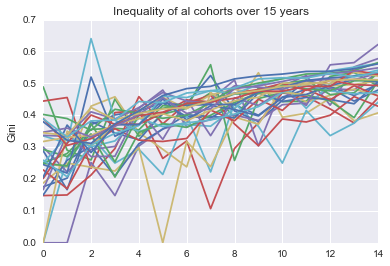

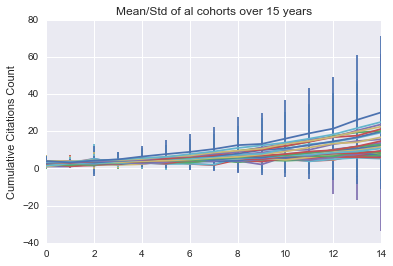

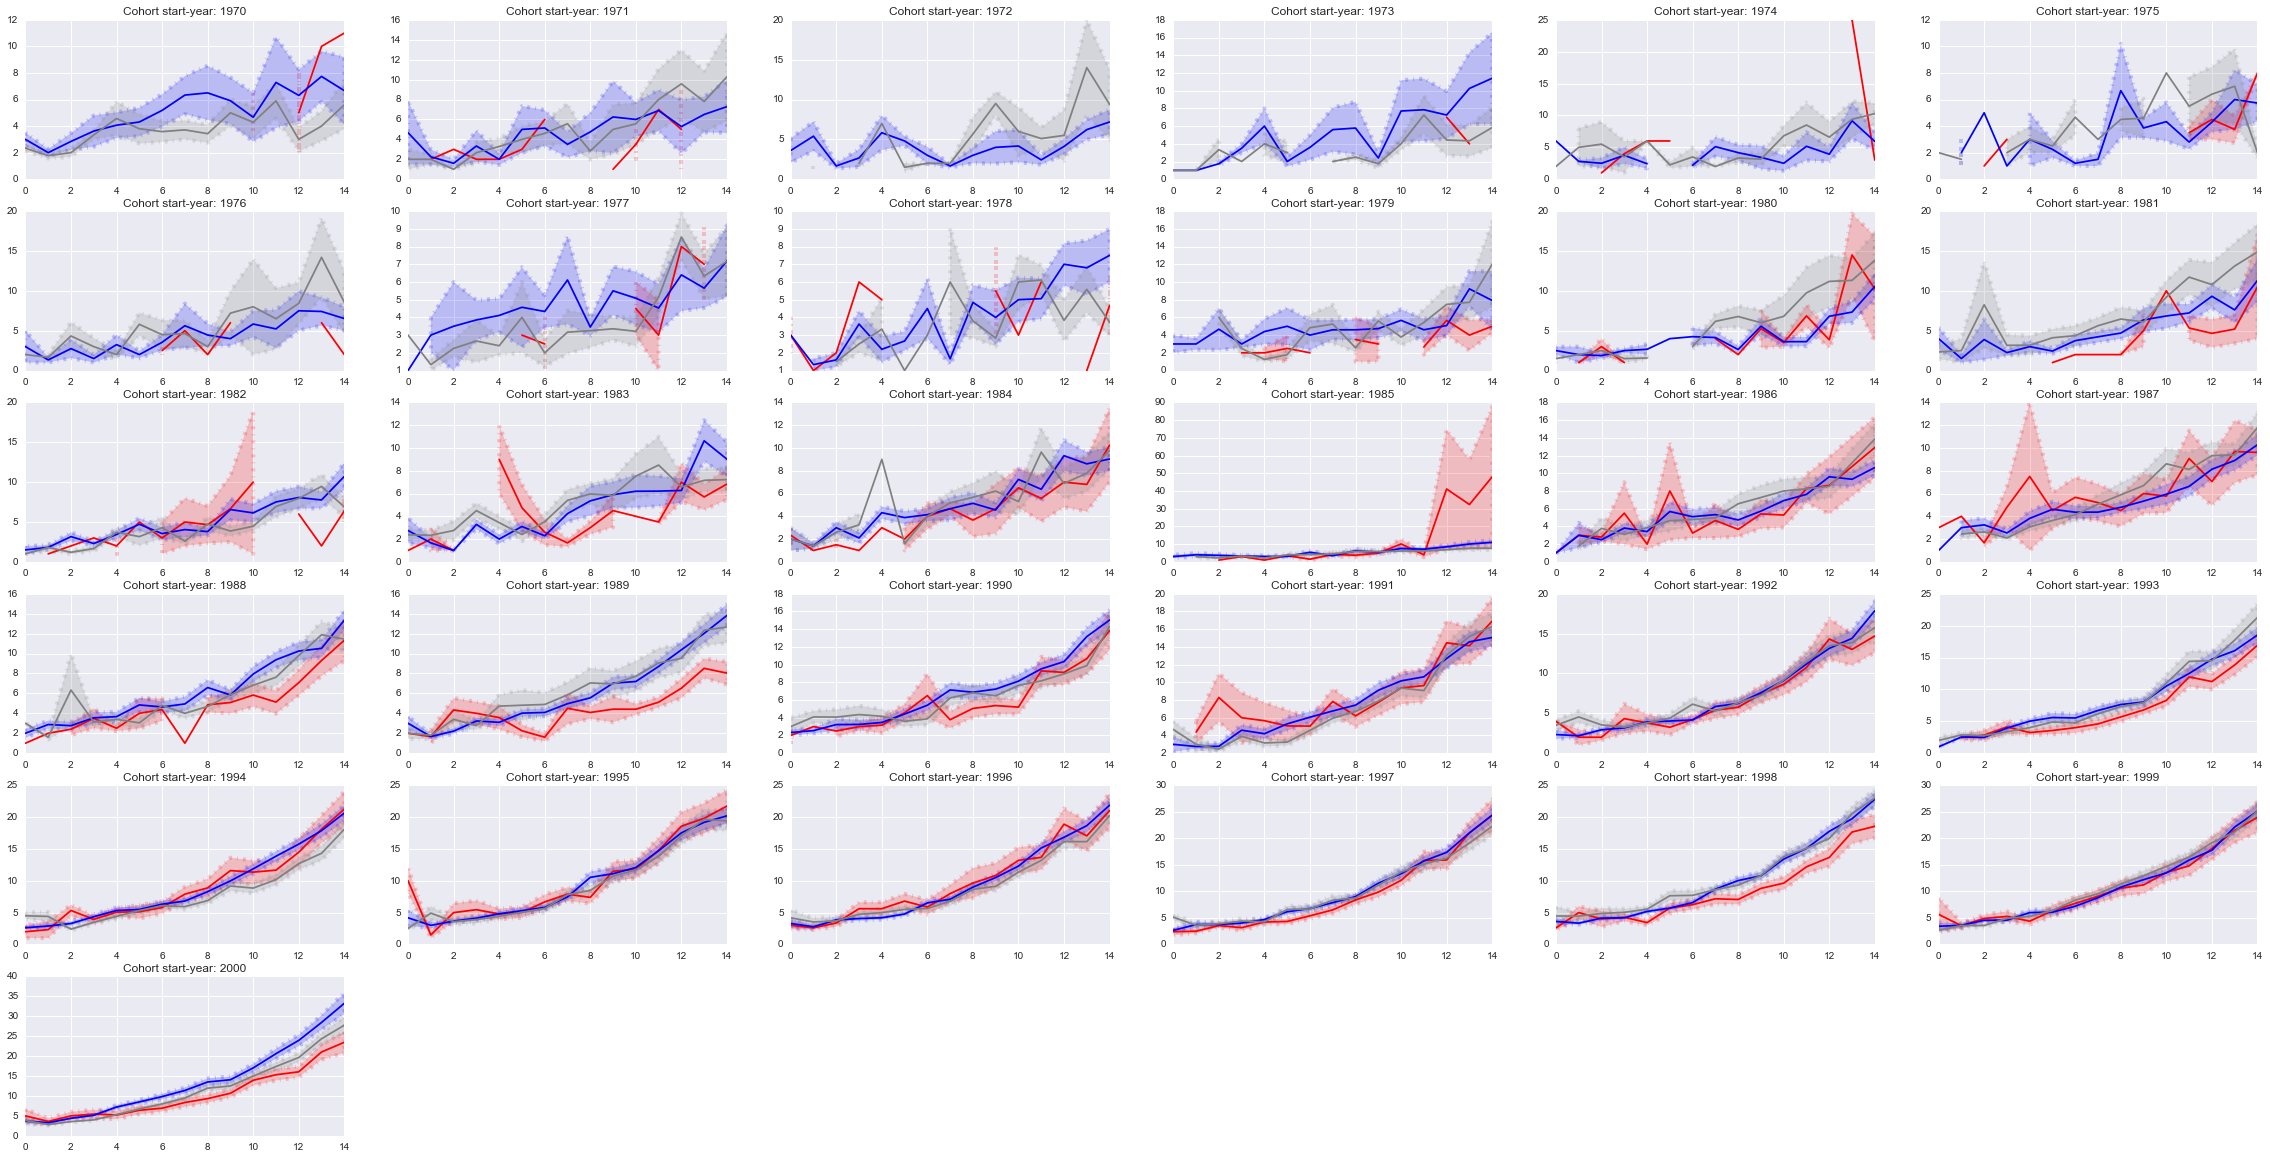

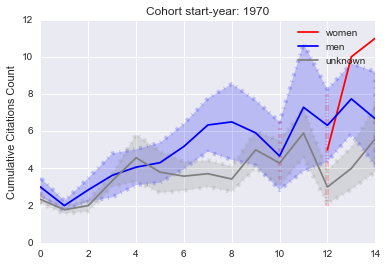

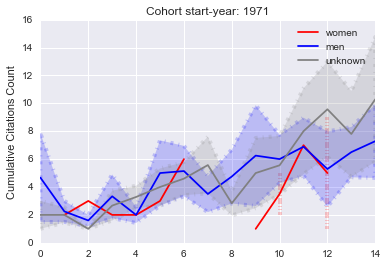

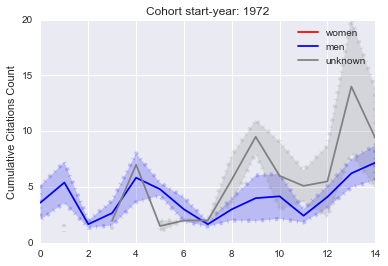

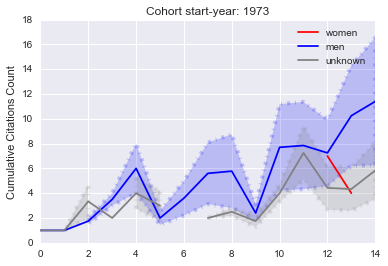

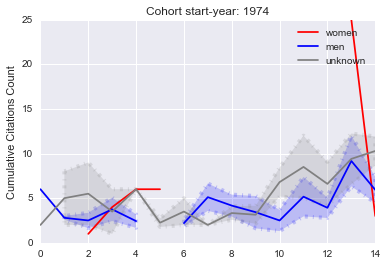

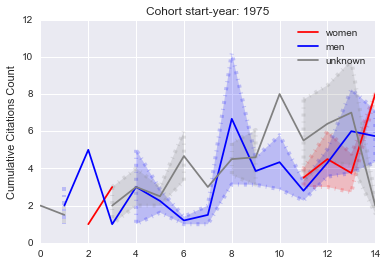

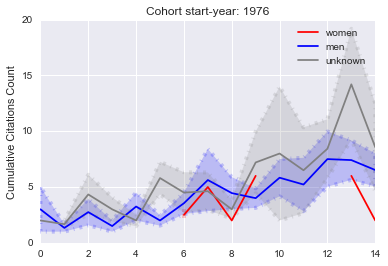

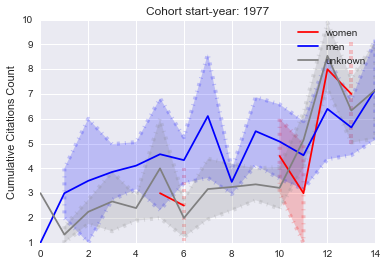

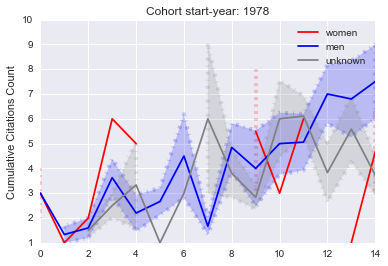

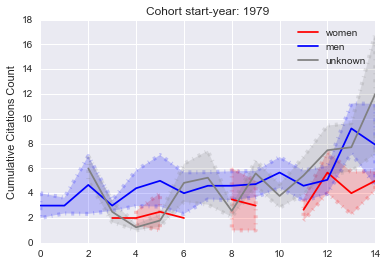

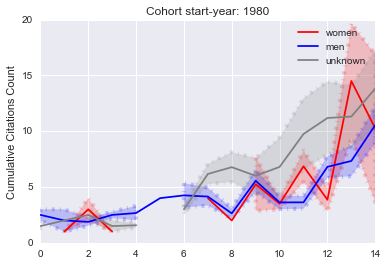

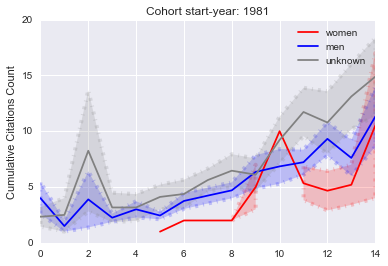

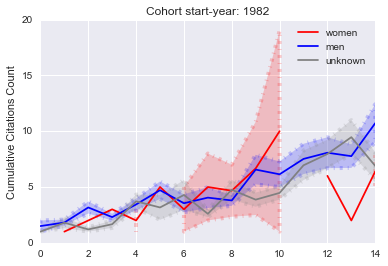

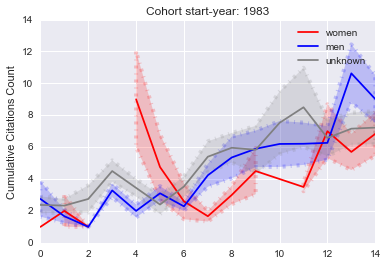

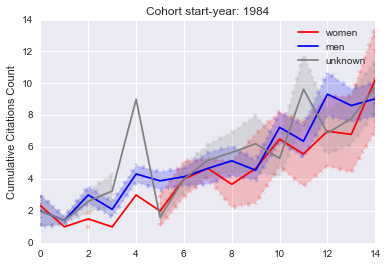

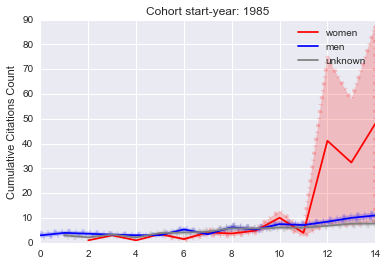

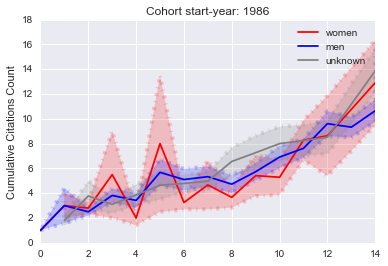

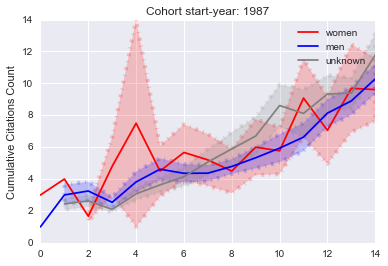

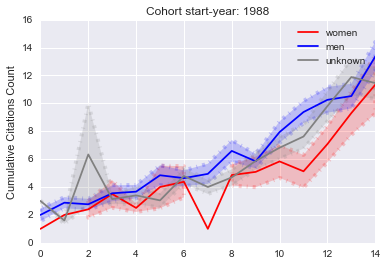

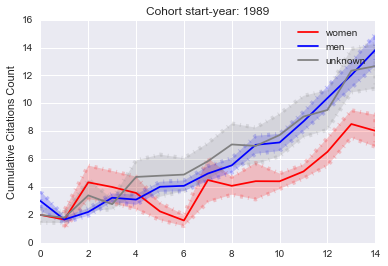

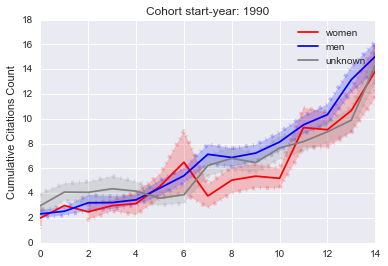

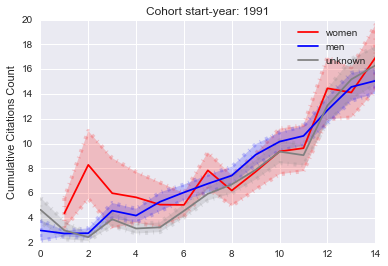

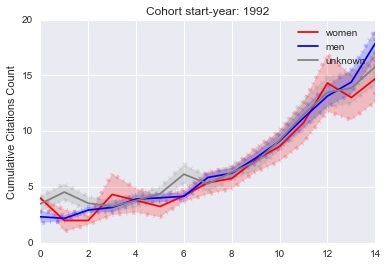

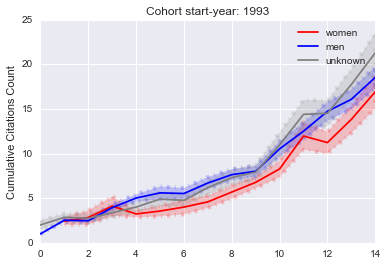

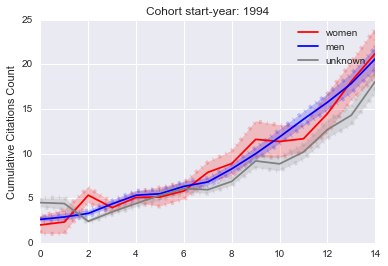

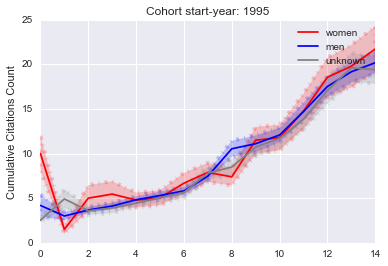

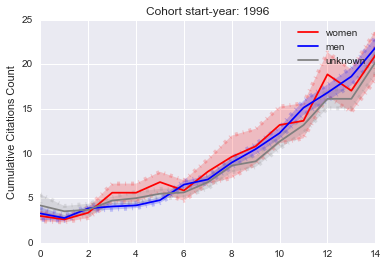

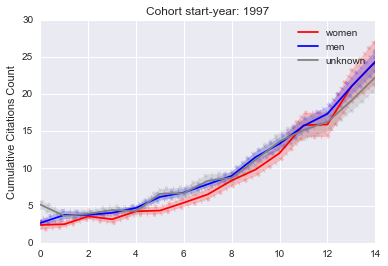

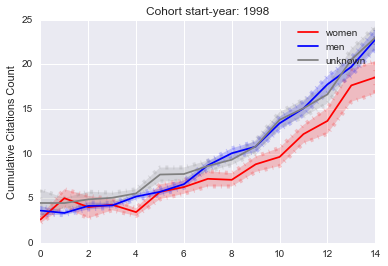

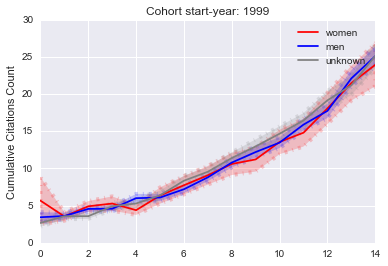

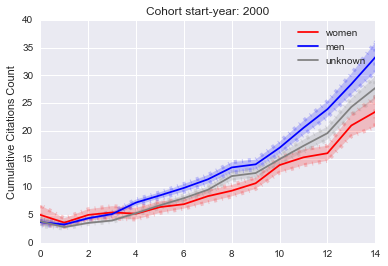

       author  start_year  end_year  pub_count  career_length gender
0  a min tjoa        1979      2015        193             36   none


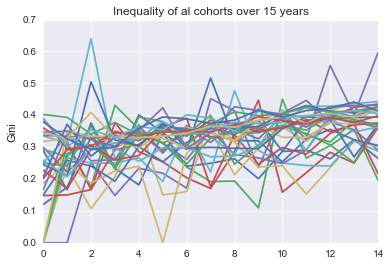

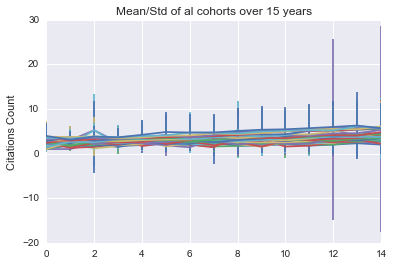

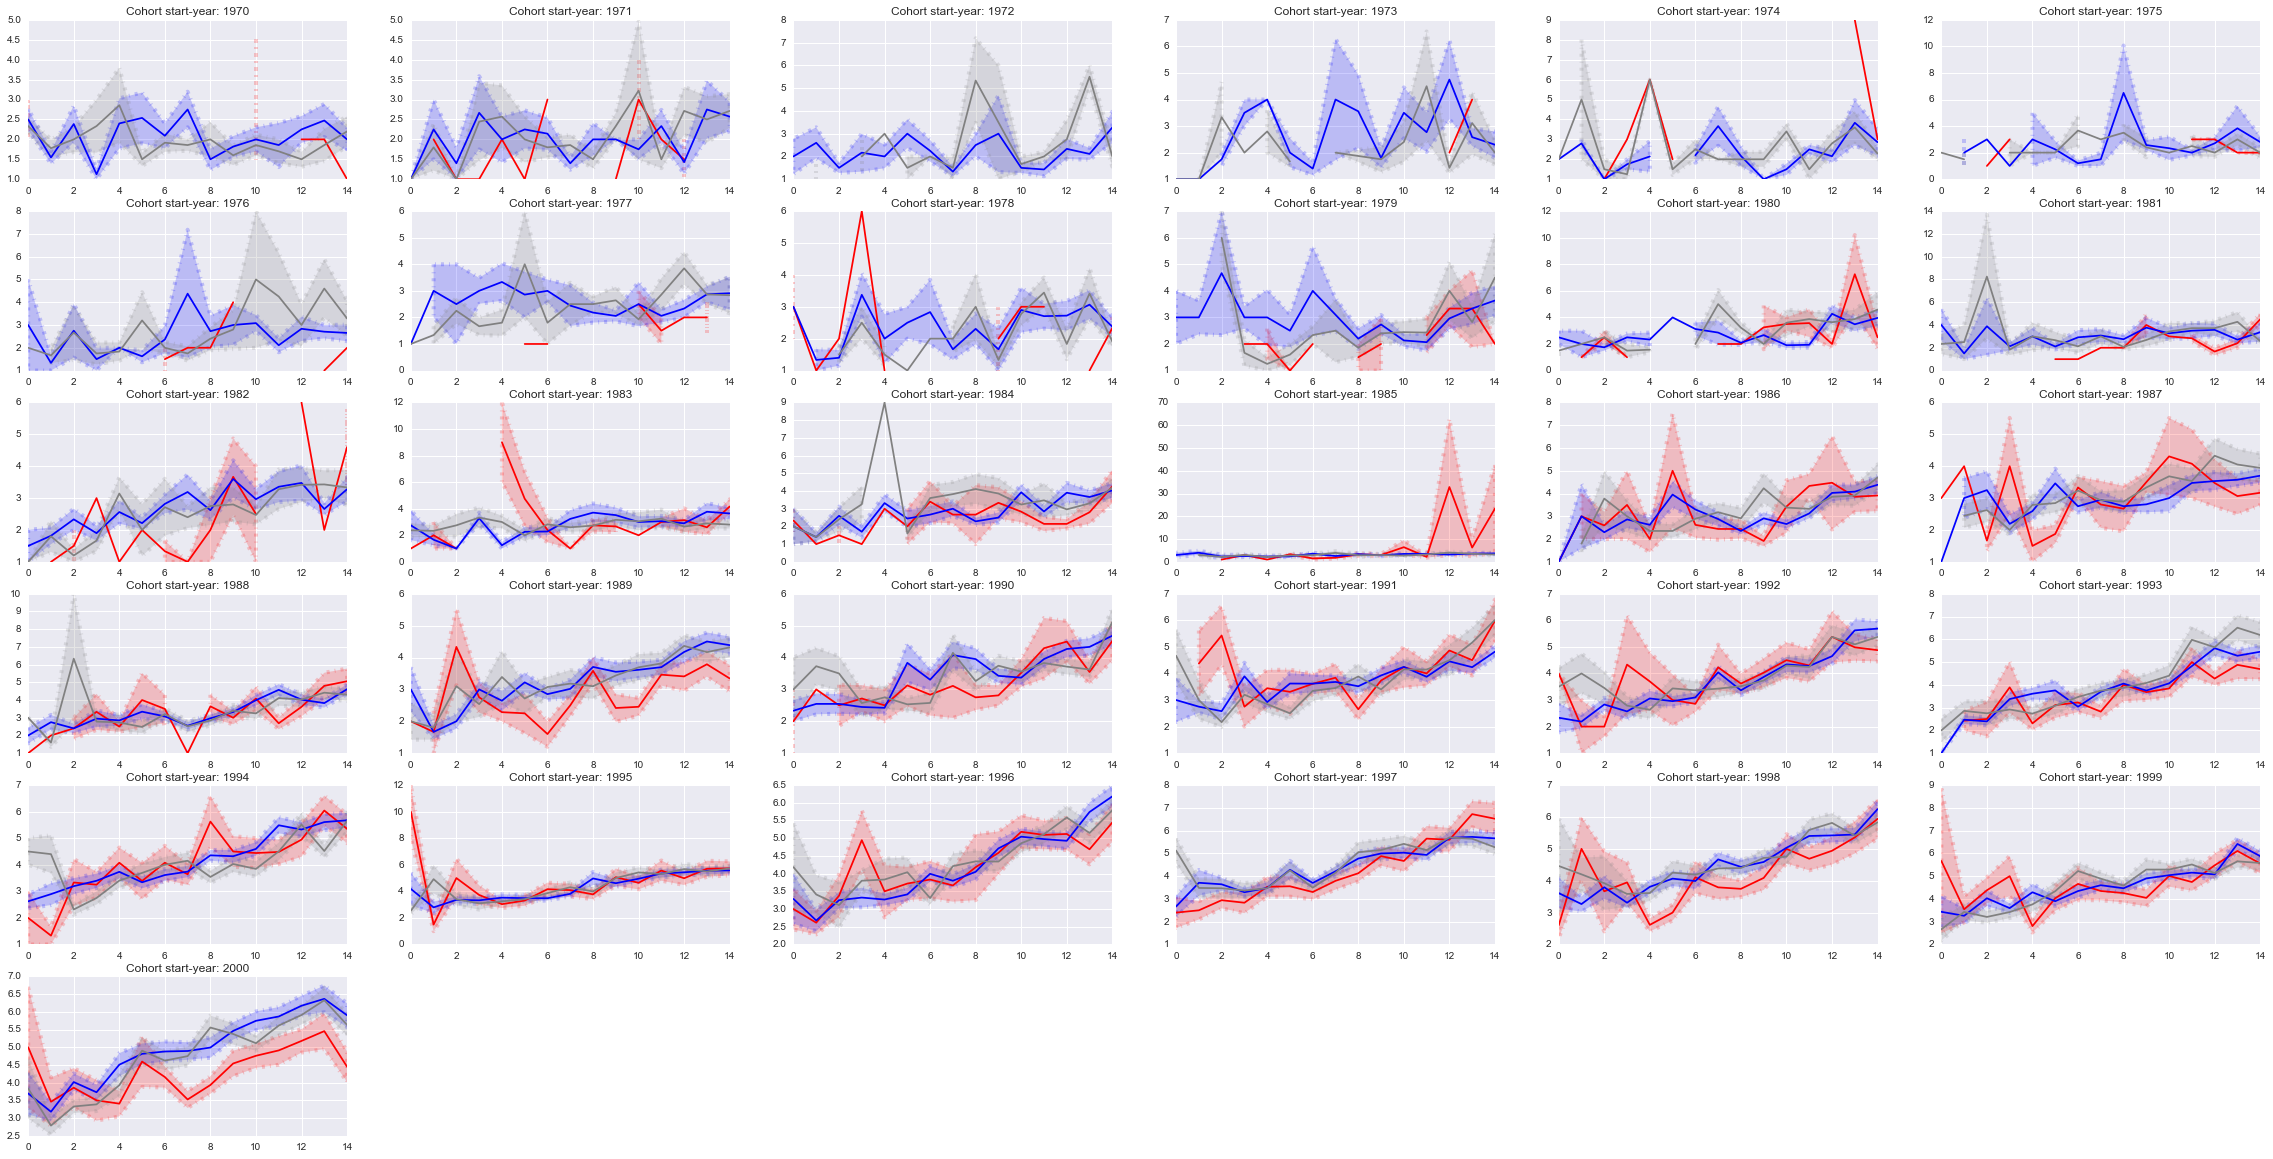

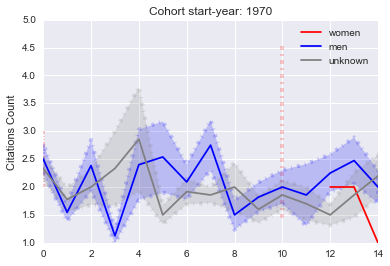

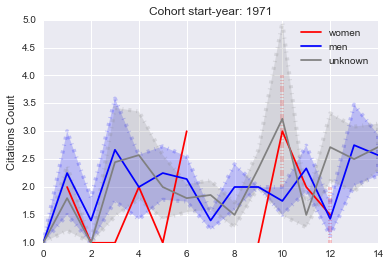

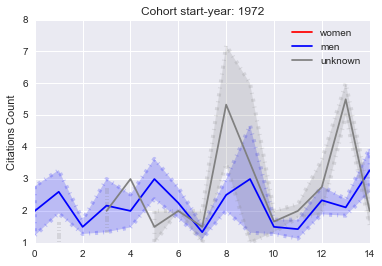

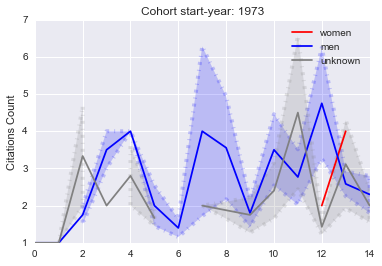

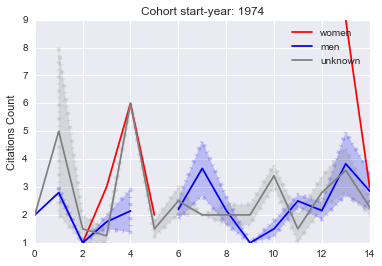

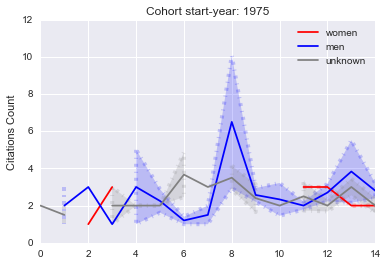

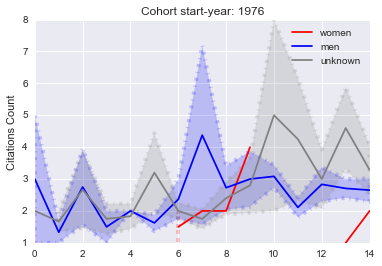

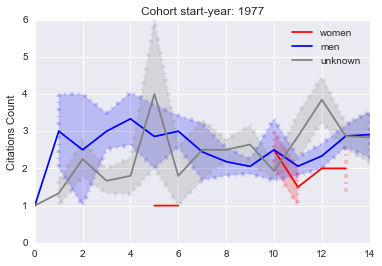

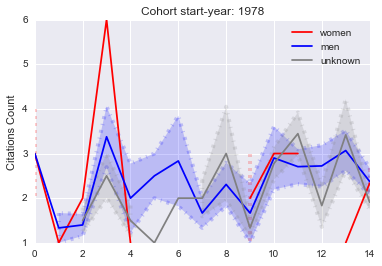

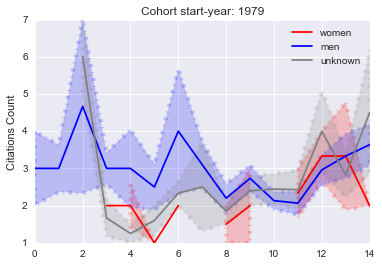

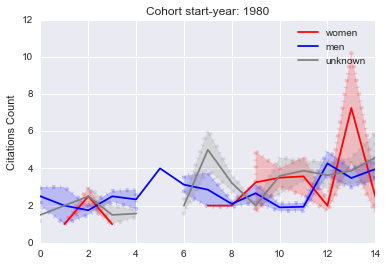

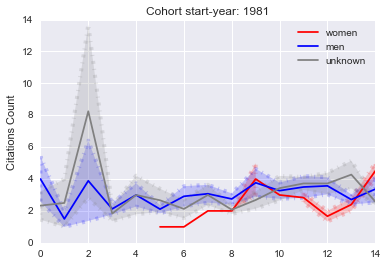

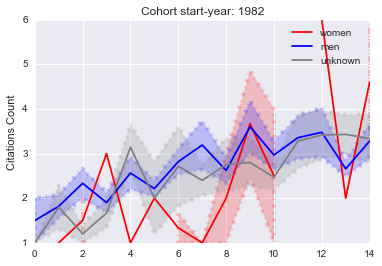

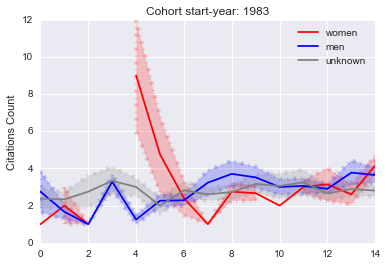

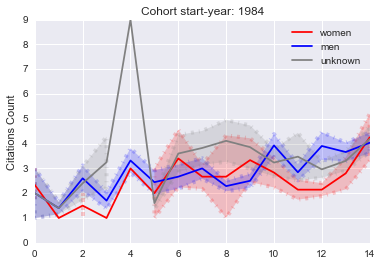

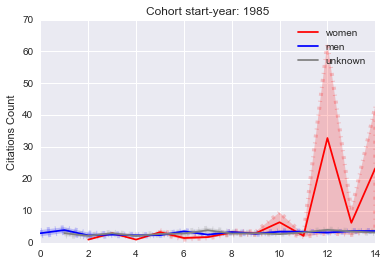

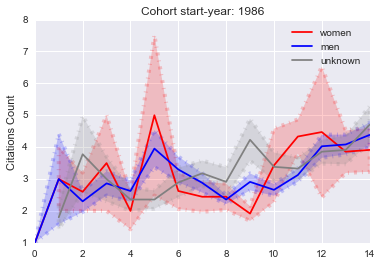

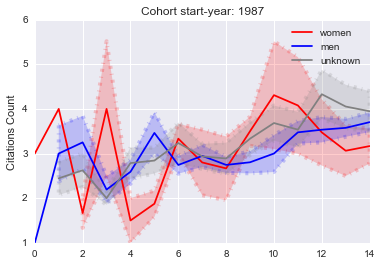

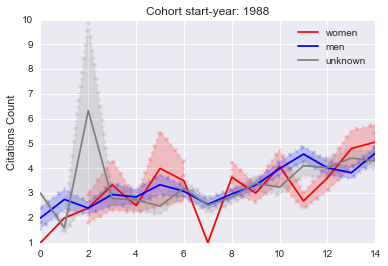

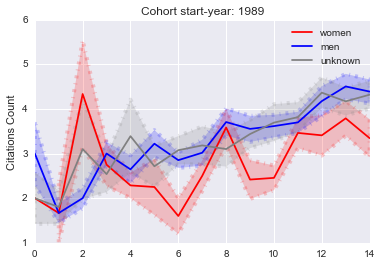

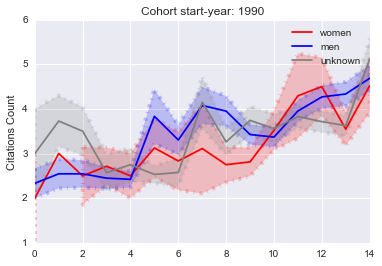

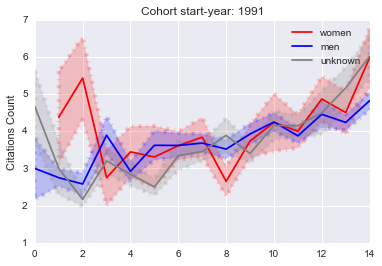

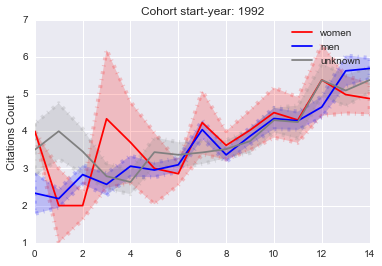

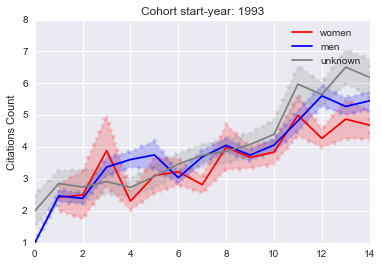

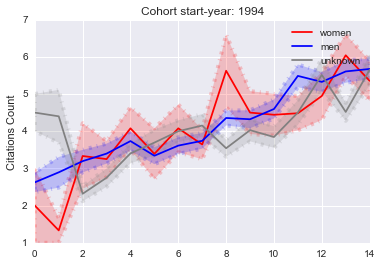

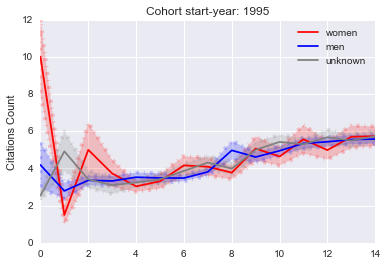

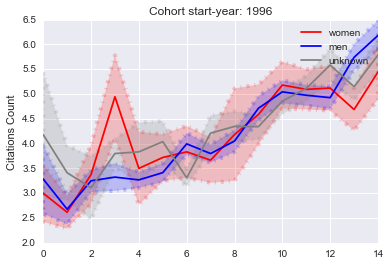

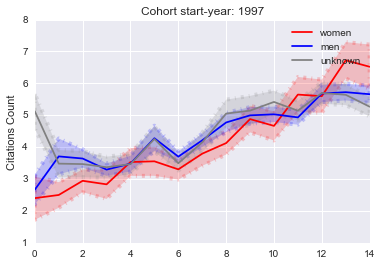

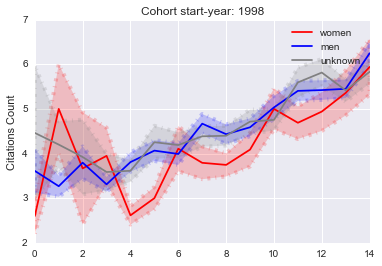

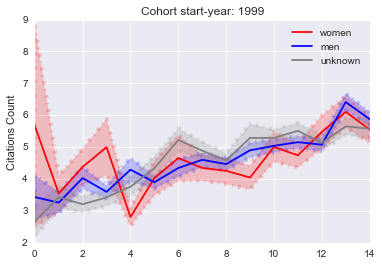

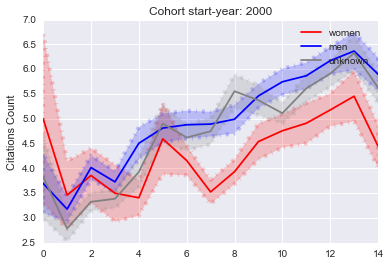

In [27]:
isCumulative = True
GROUP_YEAR = 1
plot.plot_cohort_analysis_on(groupCitationsByAuthorYearData, 'num_cit', GROUP_YEAR, isCumulative, 'Cumulative Citations Count')

isCumulative = False
GROUP_YEAR = 3
plot.plot_cohort_analysis_on(groupCitationsByAuthorYearData, 'num_cit', GROUP_YEAR, isCumulative, 'Citations Count')